<a href="https://colab.research.google.com/github/marinasr00/TADM/blob/main/Copia_de_TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes_(Oficial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 209MB/s]


1. Cargamos la extensión sql

In [ ]:
%load_ext sql

2. Nos conectamos con la base de datos

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado (status)?

In [ ]:
%%sql
SELECT status, count(*) as total
FROM loan
GROUP BY status
ORDER BY total DESC 



 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

In [ ]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


substr(l.date,0,3) --> coger los 3 primeros digitos de la fecha

3. Obtenemos el DataFrame

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [ ]:
df_train.shape

(234, 7)

Para la parte de *test* lo que vamos a extraer de la Base de Datos son los préstamos que están en ejecución (`status in ("C", "D")`) con los mismos campos que en la consulta anterior.

In [ ]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


In [ ]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


In [ ]:
df_test.shape

(448, 7)

--------------------------------------------------------------------------------

**Ejercicio**: *Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos adicionales*

* Datos de entrenamiento (train):

In [2]:
%%sql loans_train3 << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, A4, A9, birth_number, 
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and c.district_id = d.A1 and l.status in ("A", "B") 

UsageError: Cell magic `%%sql` not found.


* Datos prueba (test):

In [1]:
%%sql loans_test3 << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, A4, A9, birth_number, 
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and c.district_id = d.A1 and l.status in ("C", "D") 

UsageError: Cell magic `%%sql` not found.


--------------------------------------------------------------------------------

4. División de los datos en entrenamiento y test

`features` es una variable de tipo lista que me almacena los nombres de las características que me sirven como **entrada**

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

* train (creación del modelo) : datos de préstamos ya finalizados
* test (evaluación del modelo): datos de préstamos en ejecución

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

Hay distintos tipos de modelos NaiveBayes: GaussianNB,MultinomialNB, BernoulliNB, ComplementNB. 


En este caso se va a utilizar el *Gaussiano*:

In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) 

*Nota: se hace con los datos de prueba (test). El total de la matriz debe ser 448 que son sus dimensiones.*

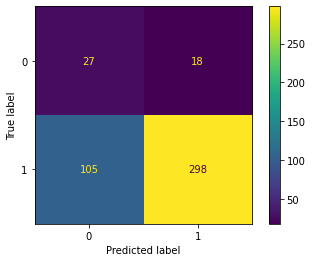

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Se han acertado 325 préstamos de 448.

2.  **Ejercicio**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

- *Datos de entrenamiento:*


In [ ]:
%%sql loans_train5 << SELECT substr(l.date,0,3) year, l.amount, duration, payments, A11, A13, A4, A9, birth_number, client_id,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and c.district_id = d.A1 and l.status in ("A", "B") 

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train5


In [ ]:
df_train5 = loans_train5.DataFrame()
df_train5.head()

,year,amount,duration,payments,A11,A13,A4,A9,birth_number,client_id,label
0,93,96396,12,8033,9650,3.67,94812,10,515911,29,0
1,93,96396,12,8033,9650,3.67,94812,10,330425,197,0
2,93,96396,12,8033,9650,3.67,94812,10,545421,470,0
3,93,96396,12,8033,9650,3.67,94812,10,635102,524,0
4,93,96396,12,8033,9650,3.67,94812,10,690814,525,0


In [ ]:
df_train5.shape

(38951, 11)

- *Datos prueba (test):*

In [ ]:
%%sql loans_test5 << SELECT substr(l.date,0,3) year, l.amount, duration, payments, A11, A13, A4, A9, birth_number, client_id,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and c.district_id = d.A1 and l.status in ("C", "D") 

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test5


In [ ]:
df_test5 = loans_test5.DataFrame()
df_test5.head()

,year,amount,duration,payments,A11,A13,A4,A9,birth_number,client_id,label
0,94,253200,60,4220,9893,4.72,228848,6,620209,31,1
1,94,253200,60,4220,9893,4.72,228848,6,680125,39,1
2,94,253200,60,4220,9893,4.72,228848,6,350817,42,1
3,94,253200,60,4220,9893,4.72,228848,6,430123,101,1
4,94,253200,60,4220,9893,4.72,228848,6,686230,106,1


In [ ]:
df_test5.shape

(60289, 11)

- Dividimos los datos de entrenamiento y de prueba: 

*Nota*:

 train (creación del modelo) : datos de préstamos ya finalizados
 
 test (evaluación del modelo): datos de préstamos en ejecución



In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13", "A4", "A9", "birth_number", "client_id"]

In [ ]:
X_train5 = df_train5[features]
y_train5 = df_train5["label"]

X_test5 = df_test5[features]
y_test5 = df_test5["label"]

Se va a normalizar para obtener mejores resultados. Se va a utilizar el StandardScaler:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train5) 
# transformación
X_train5 = scaler.transform(X_train5)
X_test5 = scaler.transform(X_test5)

Se va a aplicar un modelo NaiveBayes para construir un clasificador de préstamos

Hay distintos tipos de modelos NaiveBayes: GaussianNB,MultinomialNB, BernoulliNB, ComplementNB.

En este caso, se utilizará el Gaussiano:

In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
clf = gnb.fit(X_train5, y_train5)
y_pred = clf.predict(X_test5)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test5.shape[0], (y_test5 != y_pred).sum()))


Número de préstamos clasificados erroneamente 60289 de un total de  15251


Y, también, se va a calcular a partir del método Bernoulli: 

In [ ]:
from sklearn.naive_bayes import BernoulliNB 
gnb = BernoulliNB()
clf = gnb.fit(X_train5, y_train5)
y_pred = clf.predict(X_test5)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test5.shape[0], (y_test5 != y_pred).sum()))

Número de préstamos clasificados erroneamente 60289 de un total de  14364


Se percibe como con el método de Bernoulli disminuyen los fallos con respecto al método de Gauss.

Para ver que resultados tenemos sobre la colección de test utilizamos en primer lugar el informe de los resultados **classification report**:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test5, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.15      0.31      0.20      5817
           1       0.92      0.81      0.86     54472

    accuracy                           0.76     60289
   macro avg       0.53      0.56      0.53     60289
weighted avg       0.84      0.76      0.80     60289



Y, finalmente, la matriz de confusión respecto a los datos de prueba (test):

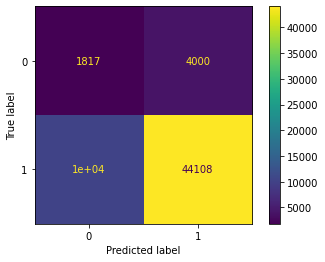

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test5, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Se han acertado un total de 45.925 préstamos de 60.289.